<a id="1"></a> <br>
<font color='red'>
#  Data Preparation 


##  Importing libraries 

In [1]:
# data processing and linear algebra

import numpy as np 
import pandas as pd 
from numba import njit

#Data Visualiation
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set()
import cv2 as cv

# Machine learning algorithme
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA

from glob import glob
from skimage import io
from os import listdir
import pickle

import random
from pprint import pprint
import time
import copy
from tqdm.notebook import tqdm
tqdm().pandas();5

print('import complete')

|          | 0/? [00:00<?, ?it/s]

import complete


## B) Exploring the data

In [2]:
data = listdir("../input/breast-histopathology-images/IDC_regular_ps50_idx5")
len(data)

279

In [3]:
file = listdir("../input/breast-histopathology-images")
len(file)

280

#### We have a total number of about 280 sub-folders, let's take a peak into the folder and try and understand what those sub-folders are.

#### Each subfolder seems to be the ID of the corresponding patient

In [4]:
patient_file = listdir("../input/breast-histopathology-images/IDC_regular_ps50_idx5/13689")
len(patient_file)

2

In [5]:
patient_file

['0', '1']

#### Each file has 2 sub-folders, labeled 1 and 0
1. Folder 0: Non-Invasive Ductal Carcinoma (IDC)
2. Folder 1 : Invasive Ductal Carcinoma (IDC)

In [6]:
zero = listdir('../input/breast-histopathology-images/IDC_regular_ps50_idx5/13689/0')
one = listdir('../input/breast-histopathology-images/IDC_regular_ps50_idx5/13689/1')

## conclusion

In [7]:
train = '../input/breast-histopathology-images/IDC_regular_ps50_idx5/'
patient_ids = listdir(train)

In [8]:
class_0_total = 0
class_1_total = 0

In [9]:
for patient_id in patient_ids:
    class_0_files = listdir(train + patient_id + '/0')
    class_1_files = listdir(train + patient_id + '/1')

    class_0_total += len(class_0_files)
    class_1_total += len(class_1_files) 

total_images = class_0_total + class_1_total
    
print(f'Number of patches in Class 0: {class_0_total}')
print(f'Number of patches in Class 1: {class_1_total}')
print(f'Total number of patches: {total_images}')

Number of patches in Class 0: 198738
Number of patches in Class 1: 78786
Total number of patches: 277524


## Storing the image_path, patient_id, target and x & y coordinates

In [10]:
columns = ["patient_id",'x','y',"target","path"]
data_rows = []
i = 0
iss = 0
isss = 0

# note that we loop through the classes after looping through the 
# patient ids so that we avoid splitting our data into [all class 0 then all class 1]
for patient_id in patient_ids:
    for c in [0,1]:
        class_path = train + patient_id + '/' + str(c) + '/'
        imgs = listdir(class_path)
        
        # Extracting Image Paths
        img_paths = [class_path + img + '/' for img in imgs]
        
        # Extracting Image Coordinates
        img_coords = [img.split('_',4)[2:4] for img in imgs]
        x_coords = [int(coords[0][1:]) for coords in img_coords]
        y_coords = [int(coords[1][1:]) for coords in img_coords]

        for (path,x,y) in zip(img_paths,x_coords,y_coords):
            values = [patient_id,x,y,c,path]
            data_rows.append({k:v for (k,v) in zip(columns,values)})


In [11]:
# We create a new dataframe using the list of dicts that we generated above
data = pd.DataFrame(data_rows)
print(data.shape)
data

(277524, 5)


,patient_id,x,y,target,path
0,10295,1351,1101,0,../input/breast-histopathology-images/IDC_regu...
1,10295,1501,501,0,../input/breast-histopathology-images/IDC_regu...
2,10295,1501,1101,0,../input/breast-histopathology-images/IDC_regu...
3,10295,451,901,0,../input/breast-histopathology-images/IDC_regu...
4,10295,801,451,0,../input/breast-histopathology-images/IDC_regu...
...,...,...,...,...,...
277519,12873,1601,901,1,../input/breast-histopathology-images/IDC_regu...
277520,12873,1001,801,1,../input/breast-histopathology-images/IDC_regu...
277521,12873,1001,851,1,../input/breast-histopathology-images/IDC_regu...
277522,12873,1401,451,1,../input/breast-histopathology-images/IDC_regu...


# Data Analysis

In [12]:
#default theme
sns.set(context='notebook', style='darkgrid', palette='colorblind', font='sans-serif', font_scale=1, rc=None)
matplotlib.rcParams['figure.figsize'] =[8,8]
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams['font.family'] = 'sans-serif'

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


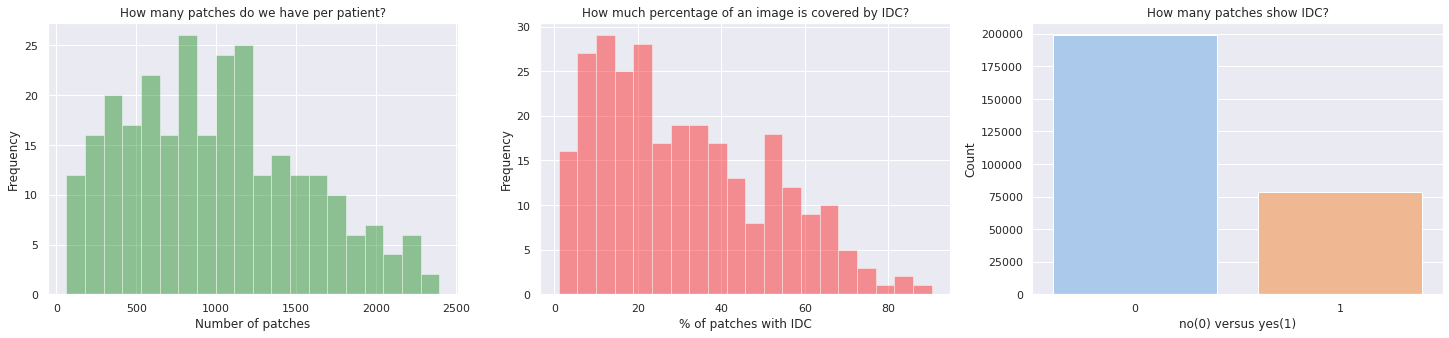

In [13]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(25,5))

# Plotting Frequency of Patches per Patient
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="green", kde=False, bins=20)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")

# Plotting Percentage of an image that is covered by Invasive Ductile Carcinoma
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="red", kde=False, bins=20)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC")

# Plotting number of patches that show IDC
sns.countplot(data.target, palette='pastel', ax=ax[2]);
ax[2].set_ylabel("Count")
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

### Healthy Tissue Patches Vs Cancerous Tissue Patches
Let us now explore the visual differences between cancerous tissue cells, and healthy tissue cells. 
Usually partnering with a specialist is a good idea so that they can point the exact points of interest that differentiate the 2 from each other.

In [14]:
positive_tissue = np.random.choice(data[data.target==1].index.values, size=100, replace=False)
negative_tissue = np.random.choice(data[data.target==0].index.values, size=100, replace=False)

In [15]:
n_rows = 5
n_cols = 5

### A ) Cancerous Patches

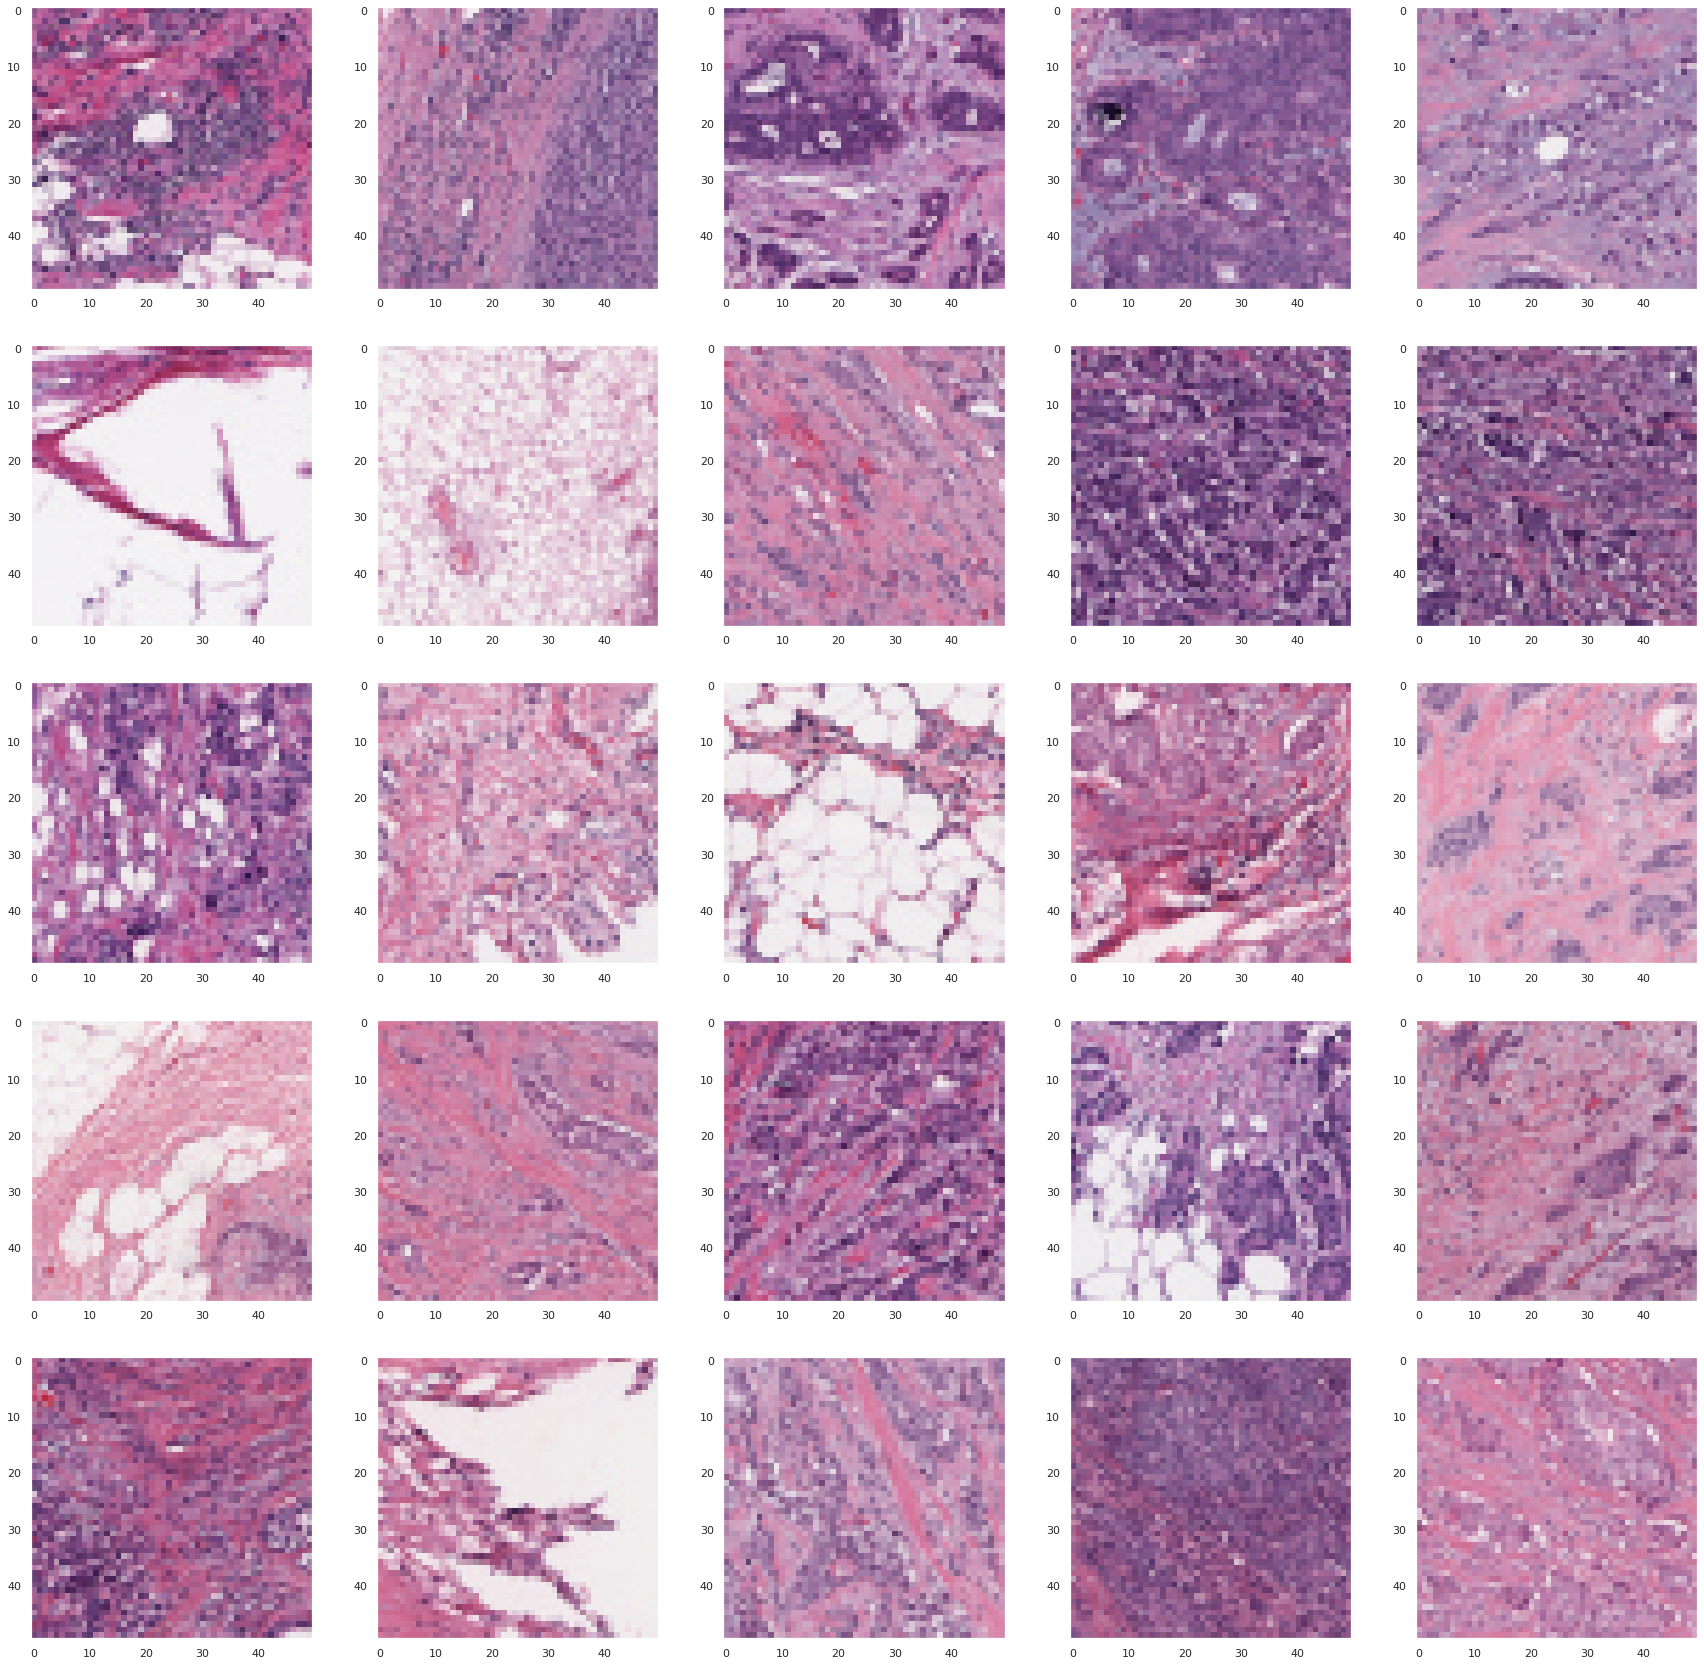

In [16]:
fig,ax = plt.subplots(n_rows,n_cols,figsize = (30,30))

for row in range(n_rows):
    for col in range(n_cols):
        # below is a counter to cycle through the image indexes
        idx = positive_tissue[col + n_cols*row]
        img = io.imread(data.loc[idx, "path"])
        ax[row,col].imshow(img[:,:,:])
        ax[row,col].grid(False)

### B) Non-Cancerous Patches

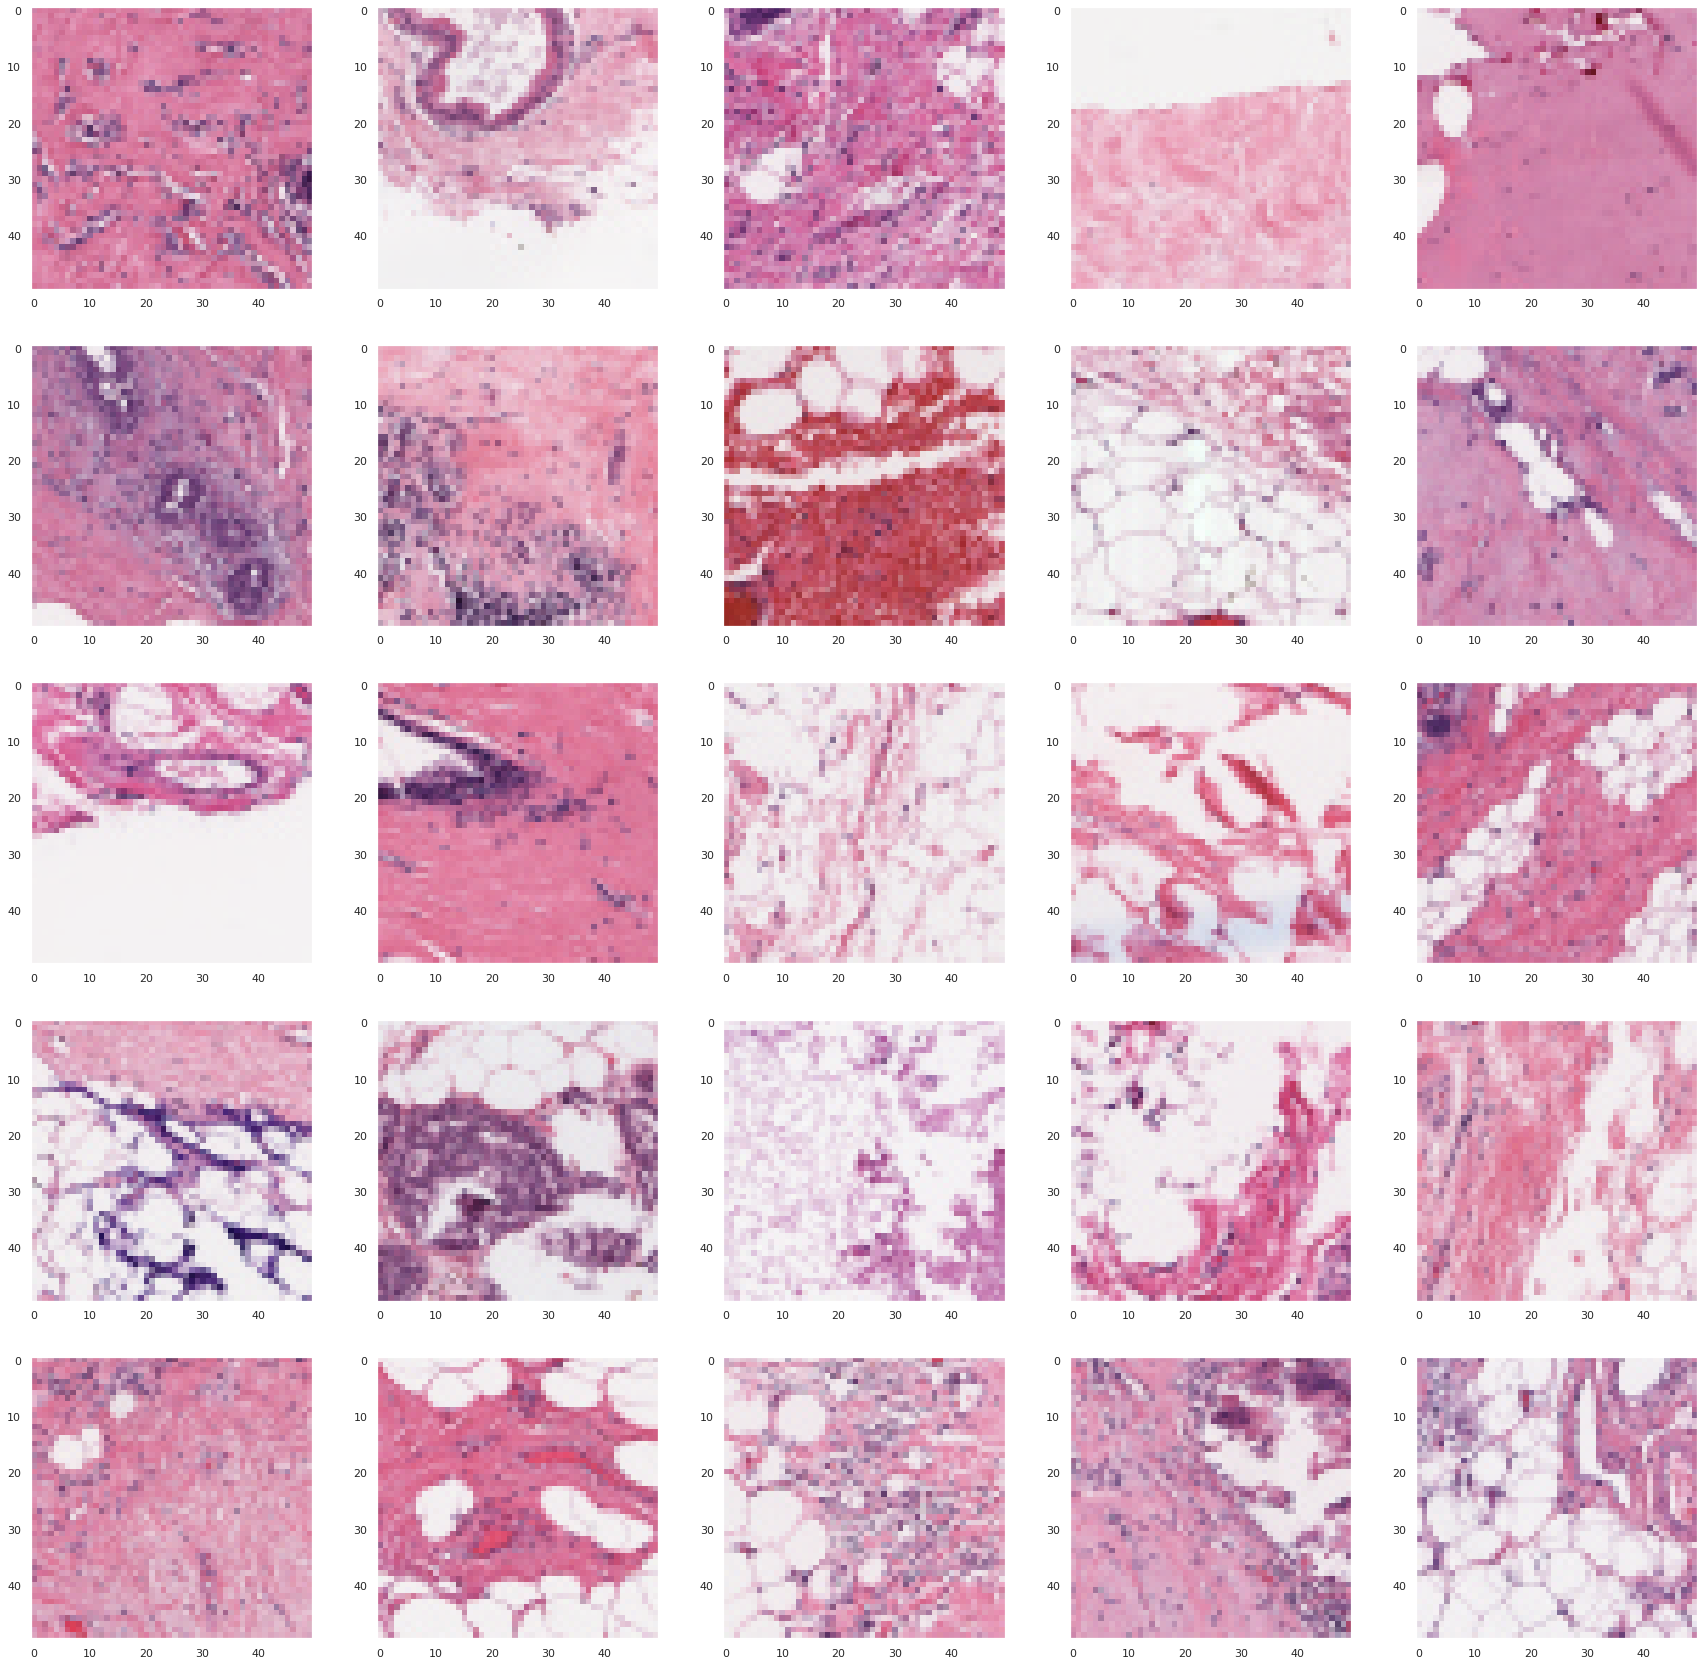

In [17]:
fig,ax = plt.subplots(n_rows,n_cols,figsize = (30,30))

for row in range(n_rows):
    for col in range(n_cols):
        # below is a counter to cycle through the image indices
        idx = negative_tissue[col + n_cols*row]
        img = io.imread(data.loc[idx, "path"])
        ax[row,col].imshow(img[:,:,:])
        ax[row,col].grid(False)

### Visualizing the Breast Tissue

Earlier we extracted the coordinates of the cropped tissue cells, we can use those coordinates to reconstruct the whole breast tissue of the patient. This way we can explore how the diseased tissue looks when compared to the healthy tissue.

We can also explore the most common places that the cancer tends to occur in. It would be interesting to plot a heatmap of the most common areas where the cancer appears.

If position of the crop has significance then perhaps we can use it as an input feature for our model.

To simplify things we will create a function that slices our existing dataframe and retrieves the values associated with a patient id.

In [18]:
def get_patient_df(patient_id):
    return data.loc[data['patient_id']== patient_id,:]

In [19]:
n_rows = 5
n_cols = 3
n_imgs = n_rows*n_cols

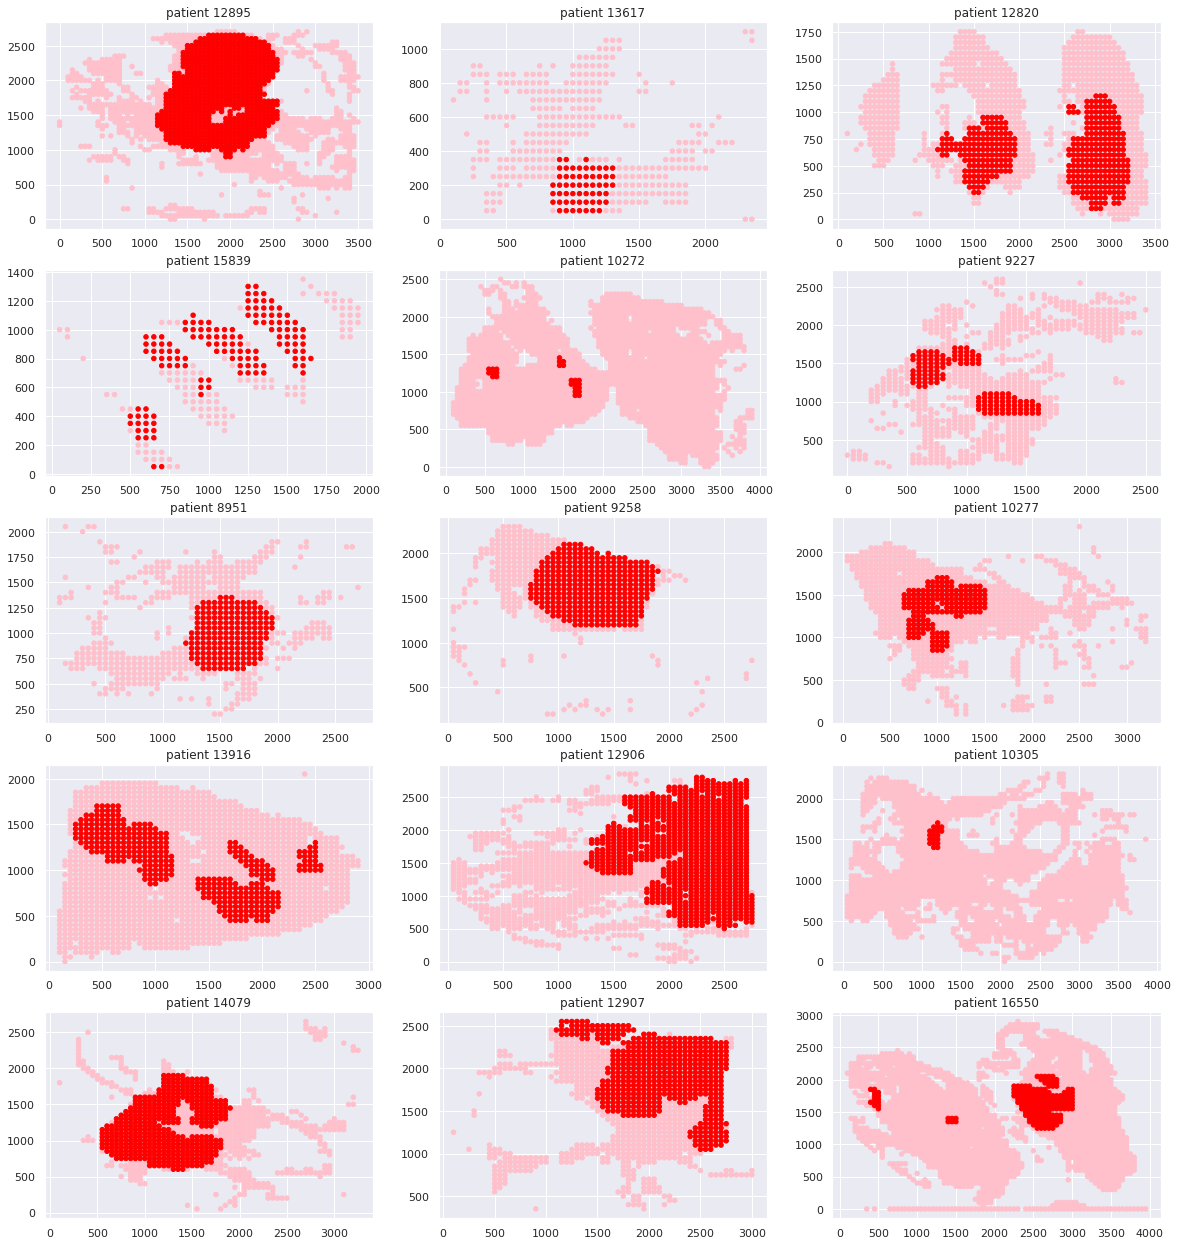

In [20]:

colors = ['pink', 'red']

fig, ax = plt.subplots(n_rows,n_cols,figsize=(20, 22))

patient_ids = np.random.choice( data.patient_id.unique(), size=n_imgs, replace=False)

for row in range(n_rows):
    for col in range(n_cols):
        patient_id = patient_ids[col + n_cols*row]
        patient_df = get_patient_df(patient_id)
        
        ax[row,col].scatter(patient_df.x.values, \
                            patient_df.y.values, \
                            c=patient_df.target.values,\
                            cmap=ListedColormap(colors), s=20)
        ax[row,col].set_title("patient " + patient_id)

In [21]:
def visualise_breast_tissue(patient_id, df = data,pred = False, crop_dimension = [50,50]):
    # Plotting Settings
    plt.xticks([])
    plt.yticks([])
    # Get patient dataframe
    p_df = get_patient_df(patient_id)
    # Get the dimensions of the breast tissue image
    max_coord = np.max((*p_df.x,*p_df.y))
    # Allocate an array to fill image pixels in,use uint8 type as you don't need an int over 255
    grid = 255*np.ones(shape = (max_coord + crop_dimension[0], max_coord + crop_dimension[1], 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_coord + crop_dimension[0], max_coord + crop_dimension[1], 3)).astype(np.uint8)
    # Replace array values with values of the image
    for x,y,target,path in zip(p_df['x'],p_df['y'],p_df['target'],p_df['path']):
        try:
            img = io.imread(path)
            # Replace array values with cropped image values
            grid[y:y+crop_dimension[1],x:x+crop_dimension[0]] = img
            # Check if target is cancerous or not
            if target != 0:
                # If the target is cancerous then, replace array values with the color blue
                mask[y:y+crop_dimension[1],x:x+crop_dimension[0]] = [0,0,255]
        except: pass
    # if prediction is not specifies then show the image normally
    if pred == False:
        io.imshow(grid)
        img = grid
    # if prediction is specified then apply a mask to the areas that contain predicted cancerous cells
    else:
        # Specify the desired alpha value
        alpha = 0.78
        # This is step is very important, adding 2 numpy arrays sets the values to float64, which is why convert them back to uint8
        img = (mask * (1.0 - alpha) + grid * alpha).astype('uint8')
        io.imshow(img)
    return img

In [22]:
n_rows = 5
n_cols = 3
n_imgs = n_rows*n_cols

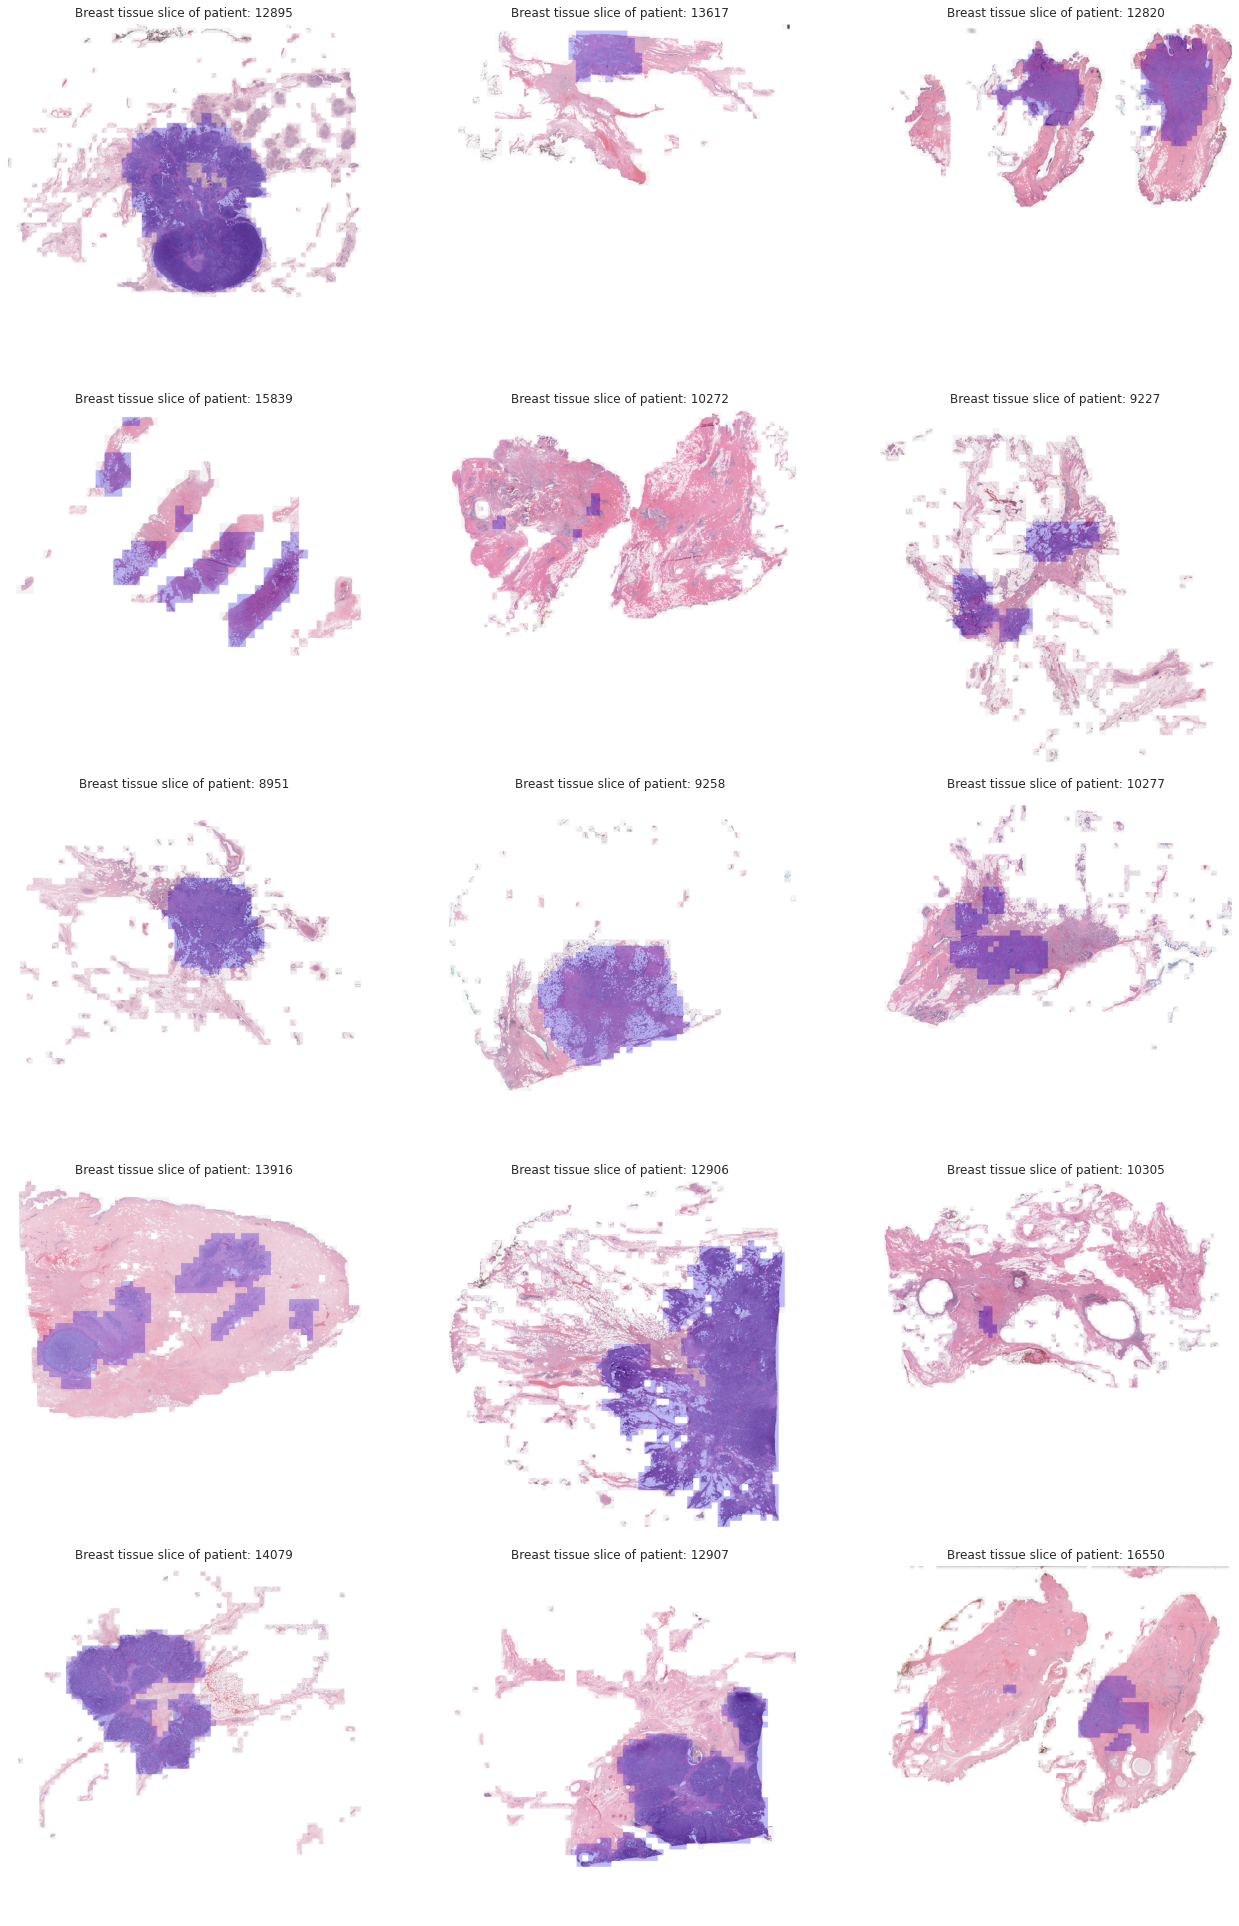

In [23]:

fig, ax = plt.subplots(n_rows,n_cols,figsize=(20, 27))

for row in range(n_rows):
    for col in range(n_cols):
        p_id = patient_ids[col + n_cols*row]
        
        img = visualise_breast_tissue(p_id, pred = True)
        ax[row,col].grid(False)
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])
        ax[row,col].set_title("Breast tissue slice of patient: " + p_id)        
        ax[row,col].imshow(img)

In [24]:
def get_classes_split(series):
    ratio = np.round(series.value_counts()/series.count()*100,decimals = 1)
    return ratio
groups = [df for _, df in data.groupby('patient_id')]
random.shuffle(groups)
shuffled_data = pd.concat(groups).reset_index(drop=True)
(get_classes_split(data['target']))

0    71.6
1    28.4
Name: target, dtype: float64

### Splitting Dataset

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
# Set the patient ids as indices for the dataframe
shuffled_data = data.set_index('patient_id')
# Select all columns except the target column and store it in X
X = shuffled_data.loc[:, shuffled_data.columns != 'target']
# Select the target column and store it in y 
y = shuffled_data['target']

# OS stands for 'Out of Sample'
X_data, OSX_df, y_data, OSy_df = train_test_split(X, y, test_size=0.1, shuffle = False)
# We split it even further and obtain the training and testing dataframes
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_data, y_data, test_size=0.3, shuffle = False)

print(f'y_data: {get_classes_split(y_data)}')
display(get_classes_split(y_test_df))
display(get_classes_split(OSy_df))

y_data: 0    72.1
1    27.9
Name: target, dtype: float64


0    72.8
1    27.2
Name: target, dtype: float64

0    67.3
1    32.7
Name: target, dtype: float64

In [27]:
# Dataframe containing cancerous images
c_df = data.loc[data.target == 1,:]
# Dataframe containing normal images
n_df = data.loc[data.target == 0,:]

fraction_c = np.round(0.7*c_df.shape[0]).astype(int)
fraction_n = np.round(0.2*n_df.shape[0]).astype(int)

rest_c_df = c_df.iloc[fraction_c:-1]
rest_n_df = n_df.iloc[fraction_n:-1]

c_df = c_df.iloc[0: fraction_c]
n_df = n_df.iloc[0: fraction_n]

nc = c_df.shape[0]
nn = n_df.shape[0]

nrc = rest_c_df.shape[0]
nrn = rest_n_df.shape[0]

total_test = nn+nc
total_train = nrn + nrc

print("Testing Data:") 
print(f'percent cancerous : {round(nc/total_test*100,1)}%')
print(f'percent non-cancerous : {round(nn/total_test*100,1)}%\n')
print("Training Data:")
print(f'percent cancerous : {round(nrc/total_train*100,1)}%')
print(f'percent non-cancerous : {round(nrn/total_train*100,1)}%')

Testing Data:
percent cancerous : 58.1%
percent non-cancerous : 41.9%

Training Data:
percent cancerous : 12.9%
percent non-cancerous : 87.1%


In [28]:
n_train_df = c_df.append(n_df, sort = True).reset_index(drop=True)
n_test_df = rest_c_df.append(rest_n_df,sort = True).reset_index(drop=True)

In [29]:
def shuffle_patients(frame):
    groups = [df for _, df in frame.groupby('patient_id')]
    random.shuffle(groups)
    shuffled_df = pd.concat(groups).reset_index(drop=True)
    return shuffled_df
n_train_df = shuffle_patients(n_train_df)
get_classes_split(n_train_df['target'])

1    58.1
0    41.9
Name: target, dtype: float64

# RGB PCA

In [30]:
import gc
from sklearn.decomposition import IncrementalPCA
def rgb_to_grayscale(img_paths, batch_size = 15000):
    # get the total number of images
    num_of_imgs = img_paths.shape[0]
    # initialize counter that keeps track of position of image being loaded
    pos = 0
    # initialize empty array in order fill in the image values
    grid = np.zeros((num_of_imgs*2500, 3))

    for img_path in tqdm(img_paths, total=num_of_imgs):
        # Read the image into a numpy array 
        img = io.imread(img_path)
        # reshape the image to such that the rgb values are the columns of the matrix
        img = img.reshape(-1, 3)
        # replace the empty array with the values inside the image
        grid[pos: pos + img.shape[0],:] = img
        # update position counter
        pos += img.shape[0]
        
    # initialize pca to reduce rgb scale to a single dimensional scale
    ipca = IncrementalPCA(n_components=1, batch_size=batch_size)
    # fit pca object to the contents within the grid
    ipca.fit(grid)
    # delete grid to free up sum memory
    del grid
    gc.collect()
    

In [31]:
img_paths = n_train_df['path']
rgb_pca = rgb_to_grayscale(img_paths)

  0%|          | 0/94898 [00:00<?, ?it/s]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for MobileNet Model')
plt.show()